# Baseline for Slot1

## Check dataset existence

In [1]:
# check data existence
from pathlib import Path


data_folder = Path.cwd().parent.joinpath("data/processed")

def check_data_existence(folder):
    file_count = len(list(folder.glob("e*_ann.json")))
    if  file_count == 0:
        raise Exception("Processed Data does not exist.")
    else:
        print("{} files exist.".format(file_count))


check_data_existence(data_folder)

stop_words = []

with Path.cwd().joinpath("resource/stop_words_ja.txt").open(encoding="utf-8") as f:
    stop_words = f.readlines()
    stop_words = [w.strip() for w in stop_words]

print("{} stop words are read.".format(len(stop_words)))

230 files exist.
310 stop words are read.


## Read Slot1 data to DataFrame

At the Slot1 task, predict E#A labels from sentence.

* It is multi-class problem, and its evaluation is used [micro-averaging](http://www.aclweb.org/anthology/S16-1002)
* Duplicate label  occurrences are ignored. 

In [2]:
label_kinds = []

# make labels (exclude NULL and OOD)
for e in ["market", "company", "business", "product"]:
    for a in ["general", "sales", "profit", "amount", "price", "cost"]:
        label_kinds.append(e + "#" + a)
        if e in ["market"]:
            break;

print(label_kinds)

['market#general', 'company#general', 'company#sales', 'company#profit', 'company#amount', 'company#price', 'company#cost', 'business#general', 'business#sales', 'business#profit', 'business#amount', 'business#price', 'business#cost', 'product#general', 'product#sales', 'product#profit', 'product#amount', 'product#price', 'product#cost']


In [3]:
# Slot1 predicts E#A label from entity and sentence
import json
import pandas as pd
from collections import Counter
from janome.tokenizer import Tokenizer


sentences = []
labels = []
tokenizer = Tokenizer(wakati=True)


def format_word(word):
    if word.isdigit():
        return "0"
    elif word in stop_words:
        return ""
    else:
        return word.strip()


def tokenize(sentence, register=True):
    tokens = tokenizer.tokenize(sentence)
    tokens = [format_word(t) for t in tokens]
    tokens = [t for t in tokens if t]
    return tokens
    

for f in data_folder.glob("e*_ann.json"):
    with f.open(encoding="utf-8") as j:
        d = json.load(j)
        for s in d["sentences"]:
            # register words
            tokenized = tokenize(s["sentence"])
            annotations = [o["category"] for o in s["opinions"]]
            
            if len(annotations) > 0:
                row = {}
                for k in label_kinds:
                    if k in annotations:
                        row[k] = 1
                    else:
                        row[k] = 0

                labels.append(row)
                sentences.append(tokenized)


labels = pd.DataFrame(labels)
labels.head(5)

,business#amount,business#cost,business#general,business#price,business#profit,business#sales,company#amount,company#cost,company#general,company#price,company#profit,company#sales,market#general,product#amount,product#cost,product#general,product#price,product#profit,product#sales
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [4]:
%matplotlib inline

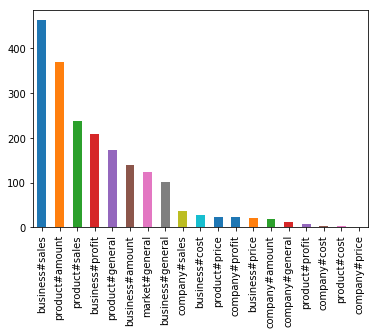

In [5]:
labels.sum(axis=0).sort_values(ascending=False).plot.bar()

In [6]:
if len(sentences) != len(labels):
    raise Exception("sentence and label count does not match!")

print("{} data is available.".format(len(labels)))

3215 data is available.


## Make Baseline Model

* Baseline Model predicts E#A labels from 1000 vocab.


In [7]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


class SentenceToVec(BaseEstimator, TransformerMixin):
    
    def __init__(self, stop_words, vector_len=1000):
        self.vocab = []
        self.stop_words = stop_words
        self.vector_len = vector_len
    
    def fit(self, X, y=None):
        self.vocab = []
        word_freq = Counter()
        for i in range(X.shape[0]):
            for w in X[i]:
                if w not in self.stop_words:
                    word_freq[w] += 1

        for term, freq in word_freq.most_common():
            if len(self.vocab) < self.vector_len:
                self.vocab.append(term)

        return self
    
    def _vectorize(self, words):
        freq = dict(Counter(words))        
        vector = []
        for v in self.vocab:
            vector.append(freq[v] if v in words else 0)
        return np.array(vector)

    def transform(self, X, copy=True):
        _X = np.zeros((X.shape[0], len(self.vocab)))
        for i in range(X.shape[0]):
            _X[i] = self._vectorize(X[i])
        return _X


model = Pipeline([("vectorize", SentenceToVec(stop_words)), ("clf", OneVsRestClassifier(LinearSVC(random_state=0)))])

## Train the Model

(3215,)
(3215, 19)
[learning_curve] Training set sizes: [ 257  835 1414 1993 2572]
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 17 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5894245723172629, total=   0.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5909797822706065, total=   1.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5723172628304821, total=   2.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5816485225505443, total=   3.3s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5723172628304821, total=   3.3s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 17 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5660964230171073, total=   0.7s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 17 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5692068429237948, total=   1.8s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5847589424572317, total=   2.2s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.6049766718506998, total=   2.9s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5769828926905132, total=   3.9s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 8 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))


[CV] ........................ , score=0.536547433903577, total=   0.7s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 8 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5645412130637636, total=   1.3s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5769828926905132, total=   2.1s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ........................ , score=0.583203732503888, total=   2.8s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ........................ , score=0.578538102643857, total=   3.4s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5318818040435459, total=   0.8s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5567651632970451, total=   1.6s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5614307931570762, total=   2.1s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5878693623639192, total=   3.3s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5894245723172629, total=   3.5s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 17 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5427682737169518, total=   0.6s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 17 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5505443234836703, total=   1.4s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5552099533437014, total=   2.0s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5552099533437014, total=   2.7s
[CV]  ................................................................


c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


[CV] ....................... , score=0.5692068429237948, total=   3.4s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.4min finished


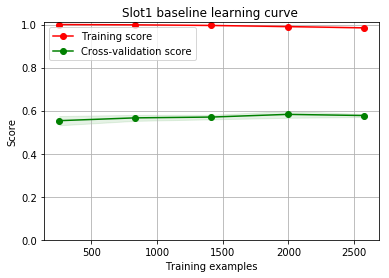

In [8]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit


# learning curve function
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(
        estimator, title, X, y, ylim=None, cv=None,
        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

X = np.array(sentences)
print(X.shape)
print(labels.shape)
plot_learning_curve(model, "Slot1 baseline learning curve ",
                    X, labels, ylim=(0.0, 1.01), cv=cv, n_jobs=1, verbose=4)

plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

f1 = []
for train_index, test_index in cv.split(X):
    model.fit(X[train_index], labels.iloc[train_index, :])
    y_pred = model.predict(X[test_index])
    y_true = labels.iloc[test_index, :]
    micro_f1 = f1_score(y_true, y_pred, average="micro")
    f1.append(micro_f1)

print("F1 is {} (+/-{})".format(np.mean(f1), np.std(f1)))

c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
c:\users\ico\documents\works\chabsa-dataset\venv\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))


F1 is 0.4477247295864218 (+/-0.02488758513807451)
